In [61]:
import numpy as np
import pandas
import pandas as pd
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans

inline_rc = dict(mpl.rcParams)

CARGAMOS LOS DATOS DE yelp_academic_dataset_review.json

In [99]:
reviews = []
with open('data/yelp_academic_dataset_review.json', encoding="ansi") as fl:
    i=0
    for review in fl:
        reviews.append(json.loads(review))
        i+=1
        if i + 1 > 200:
            break

df_review = pd.DataFrame(reviews)
print(df_review.head())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1    5.0       1      0     1   
2    3.0       0      0     0   
3    5.0       1      0     1   
4    4.0       1      0     1   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delici

CARGAMOS LOS DATOS DE yelp_academic_dataset_business.json

In [100]:
business = []
with open('data/yelp_academic_dataset_business.json', encoding="ansi") as fl:
    for i, line in enumerate(fl):
        business.append(json.loads(line))

df_business = pd.DataFrame(business)
print(df_business.head())



              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

ELIMINAMOS LAS COLUMNAS INNECESARIAS

In [101]:
df_review = df_review.drop(["review_id", "user_id", "useful", "funny", "cool", "date"], axis=1)
df_business = df_business.drop(["name", "address", "city", "state", "postal_code", "latitude", "longitude", "stars", "review_count", "is_open", "attributes", "hours"], axis=1)

COMPROBAMOS

In [66]:
print(df_review.head())
print(df_business.head())

              business_id  stars  \
0  XQfwVwDr-v0ZS3_CbbE5Xw    3.0   
1  7ATYjTIgM3jUlt4UM3IypQ    5.0   
2  YjUWPpI6HXG530lwP-fb2A    3.0   
3  kxX2SOes4o-D3ZQBkiMRfA    5.0   
4  e4Vwtrqf-wpJfwesgvdgxQ    4.0   

                                                text  
0  If you decide to eat here, just be aware it is...  
1  I've taken a lot of spin classes over the year...  
2  Family diner. Had the buffet. Eclectic assortm...  
3  Wow!  Yummy, different,  delicious.   Our favo...  
4  Cute interior and owner (?) gave us tour of up...  
              business_id                                         categories
0  Pns2l4eNsfO8kk83dixA6A  Doctors, Traditional Chinese Medicine, Naturop...
1  mpf3x-BjTdTEA3yCZrAYPw  Shipping Centers, Local Services, Notaries, Ma...
2  tUFrWirKiKi_TAnsVWINQQ  Department Stores, Shopping, Fashion, Home & G...
3  MTSW4McQd7CbVtyjqoe9mw  Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4  mWMc6_wTdE0EUBKIGXDVfA                          Brewpubs, Breweri

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

vectorizer = TfidfVectorizer()
lemma = WordNetLemmatizer()

X = []
for r in df_review["text"]: #Por cada review
    txt = word_tokenize(r.lower()) #Separa la review en palabras
    newtxt = ""
    for w in txt: #Por cada palabra en txt
        l = lemma.lemmatize(w) #se hace lo de quitar mayusculas y quitar raice y eso
        newtxt += l+" "
    X.append(newtxt)

X = vectorizer.fit_transform(X)
print(X)

  (0, 1894)	0.152148655638656
  (0, 730)	0.11135776079905366
  (0, 1667)	0.08837886490250463
  (0, 2633)	0.11455206145914351
  (0, 1650)	0.051768568869695074
  (0, 1975)	0.0761209334348927
  (0, 1664)	0.07452516671843953
  (0, 698)	0.13335035854889976
  (0, 131)	0.09937516377742768
  (0, 973)	0.0437166130330243
  (0, 1661)	0.152148655638656
  (0, 2600)	0.13335035854889976
  (0, 2622)	0.08970206440015539
  (0, 2233)	0.13335035854889976
  (0, 2651)	0.10850036148991166
  (0, 1446)	0.09109314931495022
  (0, 2461)	0.14905033343687907
  (0, 1805)	0.11455206145914351
  (0, 2561)	0.23634692173436783
  (0, 2717)	0.13335035854889976
  (0, 2602)	0.13335035854889976
  (0, 1678)	0.07159039157938284
  (0, 514)	0.08970206440015539
  (0, 1399)	0.2170007229798233
  (0, 2583)	0.1198149368709522
  :	:
  (199, 1096)	0.09690776277651486
  (199, 106)	0.08703315178905696
  (199, 2649)	0.16697103289718632
  (199, 98)	0.15346869647769604
  (199, 400)	0.08348551644859316
  (199, 1437)	0.09564195466616926
  (199

In [103]:
X= X.toarray()
X=pd.DataFrame(X)
print(X)

     0         1     2     3     4     5     6     7     8     9     ...  \
0     0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1     0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2     0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3     0.0  0.178259   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4     0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
..    ...       ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
195   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
196   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
197   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
198   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
199   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

     2718      2719  2720      2721      2722  2723  2724  2725  2726  2727  
0     0.0

In [96]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,10342,10343,10344,10345,10346,10347,10348,10349,10350,10351
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.001767,0.000313,0.000157,0.000173,0.000100,0.000100,0.000189,0.000076,0.000054,0.000047,...,0.000051,0.000025,0.000203,0.000127,0.000025,0.000076,0.000101,0.000025,0.000025,0.000025
std,0.018035,0.006407,0.004570,0.004856,0.004461,0.004461,0.007031,0.003383,0.002405,0.002100,...,0.002265,0.001133,0.009062,0.005664,0.001133,0.003398,0.004531,0.001133,0.001133,0.001133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.339624,0.180947,0.182030,0.182030,0.199517,0.199517,0.306110,0.151274,0.107551,0.093922,...,0.101313,0.050657,0.405253,0.253283,0.050657,0.151970,0.202627,0.050657,0.050657,0.050657


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn Plot Styling
sns.set(style="white", palette="husl")
sns.set_context("poster")
sns.set_style("ticks")

%matplotlib inline

# New imports, specific to this example
from scipy.cluster.hierarchy import dendrogram, linkage

def mai():
  D = 2                     # Dimensionality
  s = 4                     # Separation so we can control how far apart the means are
  mu1 = np.array([0, 0])
  mu2 = np.array([s, s])
  mu3 = np.array([0, s])

  N = 900                   # Number of samples
  X = np.zeros((N, D))
  X[:300, :] = np.random.randn(300, D) + mu1
  X[300:600, :] = np.random.randn(300, D) + mu2
  X[600:, :] = np.random.randn(300, D) + mu3

  # Call linkage on X, pass in parameter telling what type of linkage to use
  Z = linkage(X, 'ward')
  # In general, Z will have format index1, index2 for two index's in X that represent the
  # points that are joined at that moment. The third column will be the distance, which is
  # how far apart the two clusters were before being joined, and the 4th column will be
  # sample count, which is the number of points in that cluster. Hence, the size of Z will
  # be ((N - 1) x 4)
  print("Z shape", Z.shape)

  fig, ax = plt.subplots(figsize=(12,8))
  plt.title("Ward")
  dendrogram(Z)      # Call dendrogram on Z
  plt.show()

  # Now do single linkage for a different example
  fig, ax = plt.subplots(figsize=(12,8))
  Z = linkage(X, 'single')
  plt.title("Single")
  dendrogram(Z)
  plt.show()

  # And one more for complete
  fig, ax = plt.subplots(figsize=(12,8))
  Z = linkage(X, 'complete')
  plt.title("Complete")
  dendrogram(Z)
  plt.show()


Z shape (899, 4)


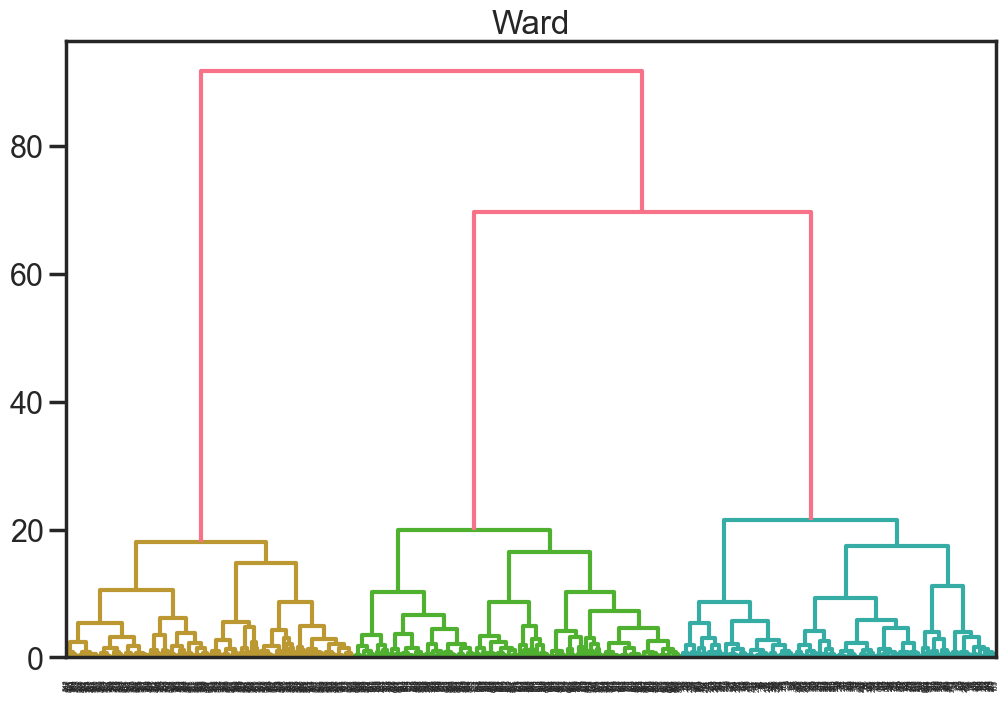

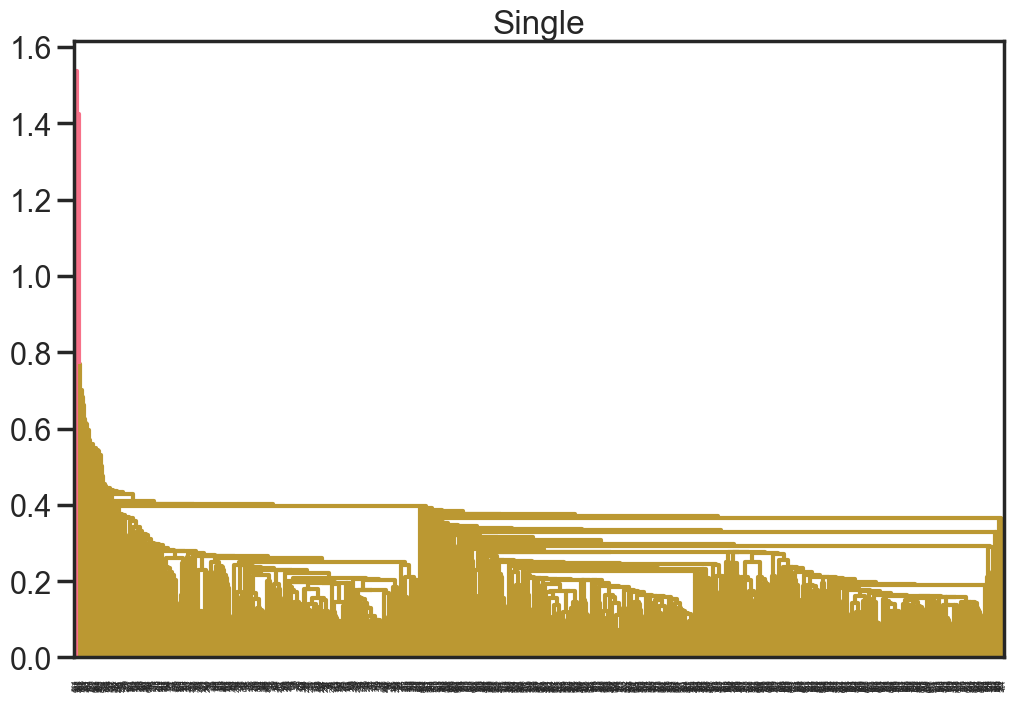

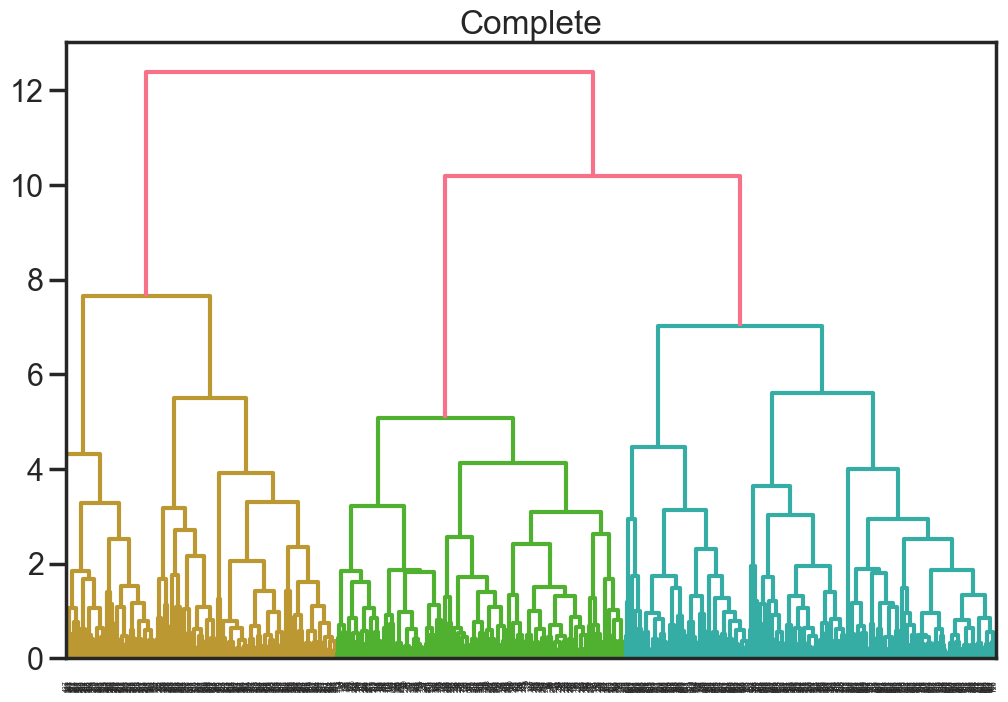

In [58]:
mai()

In [97]:
class Distance_computation_grid(object):
    '''
        class to enable the Computation of distance matrix
    '''
    def __init__(self):
        pass

    def compute_distance(self,samples):
        '''
            Creates a matrix of distances between individual samples and clusters attained at a particular step
        '''
        Distance_mat = np.zeros((len(samples),len(samples)))
        for i in range(Distance_mat.shape[0]):
            for j in range(Distance_mat.shape[0]):
                if i!=j:
                    Distance_mat[i,j] = float(self.distance_calculate(samples[i],samples[j]))
                else:
                    Distance_mat[i,j] = 10**4
        return Distance_mat


    def distance_calculate(self,sample1,sample2):
        '''
            Distance calulated between two samples. The two samples can be both samples, both clusters or
            one cluster and one sample. If both of them are samples/clusters, then simple norm is used. In other
            cases, we refer it as an exception case and pass the samples as parameter to some function that
            calculates the necessary distance between cluster and a sample
        '''
        dist = []
        for i in range(len(sample1)):
            for j in range(len(sample2)):
                try:
                    dist.append(np.linalg.norm(np.array(sample1[i])-np.array(sample2[j])))
                except:
                    dist.append(self.intersampledist(sample1[i],sample2[j]))
        return min(dist)


    def intersampledist(self,s1,s2):
        '''
            To be used in case we have one sample and one cluster . It takes the help of one
            method 'interclusterdist' to compute the distances between elements of a cluster(which are
            samples) and the actual sample given.
        '''
        if str(type(s2[0]))!='<class \'list\'>':
            s2=[s2]
        if str(type(s1[0]))!='<class \'list\'>':
            s1=[s1]
        m = len(s1)
        n = len(s2)
        dist = []
        if n>=m:
            for i in range(n):
                for j in range(m):
                    if (len(s2[i])>=len(s1[j])) and str(type(s2[i][0])!='<class \'list\'>'):
                        dist.append(self.interclusterdist(s2[i],s1[j]))
                    else:
                        dist.append(np.linalg.norm(np.array(s2[i])-np.array(s1[j])))
        else:
            for i in range(m):
                for j in range(n):
                    if (len(s1[i])>=len(s2[j])) and str(type(s1[i][0])!='<class \'list\'>'):
                        dist.append(self.interclusterdist(s1[i],s2[j]))
                    else:
                        dist.append(np.linalg.norm(np.array(s1[i])-np.array(s2[j])))
        return min(dist)

    def interclusterdist(self,cl,sample):
        if sample[0]!='<class \'list\'>':
            sample = [sample]
        dist   = []
        for i in range(len(cl)):
            for j in range(len(sample)):
                dist.append(np.linalg.norm(np.array(cl[i])-np.array(sample[j])))
        return min(dist)

In [98]:
progression = [[i] for i in range(X.shape[0])]
samples     = [[list(X[i])] for i in range(X.shape[0])]
m = len(samples)
distcal  = Distance_computation_grid()

while m>1:
    print('Sample size before clustering    :- ',m)
    Distance_mat      = distcal.compute_distance(samples)
    sample_ind_needed = np.where(Distance_mat==Distance_mat.min())[0]
    value_to_add      = samples.pop(sample_ind_needed[1])
    samples[sample_ind_needed[0]].append(value_to_add)

    print('Cluster Node 1                   :-',progression[sample_ind_needed[0]])
    print('Cluster Node 2                   :-',progression[sample_ind_needed[1]])

    progression[sample_ind_needed[0]].append(progression[sample_ind_needed[1]])
    progression[sample_ind_needed[0]] = [progression[sample_ind_needed[0]]]
    v = progression.pop(sample_ind_needed[1])
    m = len(samples)

    print('Progression(Current Sample)      :-',progression)
    print('Cluster attained                 :-',progression[sample_ind_needed[0]])
    print('Sample size after clustering     :-',m)
    print('\n')

Sample size before clustering    :-  2000


KeyboardInterrupt: 

In [80]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage

# Use the linkage() function
distance_matrix = linkage(X, method = 'ward', metric = 'euclidean')

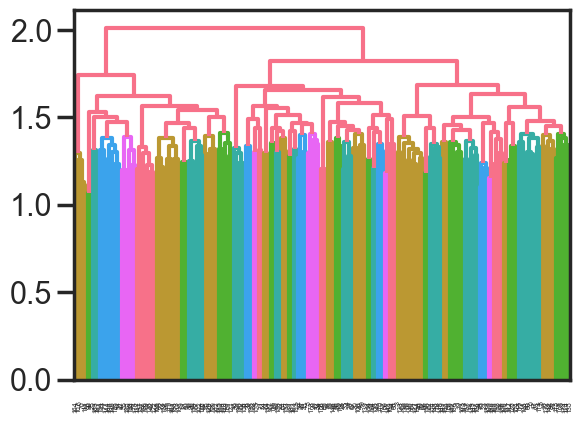

In [86]:
# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram

# Create a dendrogram
dn = dendrogram(distance_matrix)

# Display the dendogram
plt.show()